5/3/2020

atac diff analysis

https://rockefelleruniversity.github.io/RU_ATAC_Workshop.html

In [124]:
library(tidyverse)
library(org.Hs.eg.db)
# library(EnsDb.Hsapiens.v75)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(DiffBind)
library(ChIPQC)
library(ChIPseeker)
library(ChIPpeakAnno)
library(DESeq2)
library(soGGi)
library(Rsubread)
library(tracktables)


library(pheatmap)  
library(RColorBrewer)
library(viridis)
library(reshape2)
library(AnnotationDbi) 
library(Biobase)
library(limma)
library(tximport)

library(stringr)
library(Rtsne)
library(caret)  
library(clusterProfiler)
library(pheatmap)
library(ReactomePA)
library(annotate)
library(seqinr)

In [63]:
peak_files <- dir(".", pattern = "*.narrowPeak",  full.names = TRUE)
peak_files
myPeaks <- lapply(peak_files, ChIPQC:::GetGRanges, simple = TRUE)
names(myPeaks) <- c("Airway", "Astrocytes", "Bladder", "Colon", "Esophageal", "GDSD0", "GDSD3", "GDSD6", "GM12878",
                   "HMEC", "Melanocytes", "Ovarian", "Pancreas", "Prostate", "Renal", "Thyroid", "Uterine")


[1] "./Airway_rep1-rep2.idr0.05.bfilt.narrowPeak"     
 [2] "./Astrocytes_rep1-rep2.idr0.05.bfilt.narrowPeak" 
 [3] "./Bladder_rep1-rep2.idr0.05.bfilt.narrowPeak"    
 [4] "./Colon_rep1-rep2.idr0.05.bfilt.narrowPeak"      
 [5] "./Esophageal_rep1-rep2.idr0.05.bfilt.narrowPeak" 
 [6] "./GDS-D0_rep1-rep2.idr0.05.bfilt.narrowPeak"     
 [7] "./GDS-D3_rep1-rep2.idr0.05.bfilt.narrowPeak"     
 [8] "./GDS-D6_rep1-rep2.idr0.05.bfilt.narrowPeak"     
 [9] "./GM12878_rep1-rep2.idr0.05.bfilt.narrowPeak"    
[10] "./HMEC_rep1-rep2.idr0.05.bfilt.narrowPeak"       
[11] "./Melanocytes_rep1-rep2.idr0.05.bfilt.narrowPeak"
[12] "./Ovarian_rep1-rep2.idr0.05.bfilt.narrowPeak"    
[13] "./Pancreas_rep1-rep2.idr0.05.bfilt.narrowPeak"   
[14] "./Prostate_rep1-rep2.idr0.05.bfilt.narrowPeak"   
[15] "./Renal_rep1-rep2.idr0.05.bfilt.narrowPeak"      
[16] "./Thyroid_rep1-rep2.idr0.05.bfilt.narrowPeak"    
[17] "./Uterine_rep1-rep2.idr0.05.bfilt.narrowPeak"

In [65]:
myGRangesList<-GRangesList(myPeaks)   
reduced <- GenomicRanges::reduce(unlist(myGRangesList))
consensusIDs <- paste0("consensus_", seq(1, length(reduced)))
mcols(reduced) <- do.call(cbind, lapply(myGRangesList, function(x) (reduced %over% x) + 0))
reducedConsensus <- reduced
mcols(reducedConsensus) <- cbind(as.data.frame(mcols(reducedConsensus)), consensusIDs)
consensusIDs <- paste0("consensus_", seq(1, length(reducedConsensus)))


In [67]:

Group <- factor(c("purple","blue","purple","green","green","purple","purple","purple",   "grey",
                  "purple","blue", "green","green","purple", "green","green","purple"))
# consensusToCount <- soGGi:::runConsensusRegions(GRangesList(myPeaks), "none")

consensusToCount <- reducedConsensus

In [68]:
occurrences <- elementMetadata(consensusToCount) %>% as.data.frame %>% dplyr::select(-consensusIDs) %>% 
    rowSums

table(occurrences) %>% rev %>% cumsum

17     16     15     14     13     12     11     10      9      8      7 
 10646  14562  19059  23969  30590  35121  39294  43531  47991  53518  63532 
     6      5      4      3      2      1 
 72736  82995  93627 106710 125166 180669

In [73]:
consensusToCount
save(consensusToCount, file = "consensusToCount.RData")


GRanges object with 180669 ranges and 18 metadata columns:
           seqnames              ranges strand |    Airway Astrocytes   Bladder
              <Rle>           <IRanges>  <Rle> | <numeric>  <numeric> <numeric>
       [1]    chr20         71094-71649      * |         1          0         1
       [2]    chr20       174960-175243      * |         0          0         1
       [3]    chr20       189616-190068      * |         1          0         1
       [4]    chr20       200277-200455      * |         0          0         1
       [5]    chr20       216621-217042      * |         1          0         1
       ...      ...                 ...    ... .       ...        ...       ...
  [180665]     chrX 155226932-155227897      * |         0          0         1
  [180666]     chrX 155232217-155232453      * |         0          0         1
  [180667]     chrX 155233524-155233924      * |         0          0         1
  [180668]     chrX 155242809-155243544      * |         0   

ran on Sherlock

```

cd /oak/stanford/groups/khavari/users/mguo123/atac_footprinting/epithelia_output
ml R


library(tidyverse)
library(Rsubread)
library(GenomicRanges)

load('atac_diff_analysis/consensusToCount.RData')
bamsToCount <- dir("merged_bam/",full.names = TRUE, pattern = "*.\\.bam$")
bamsToCount
regionsToCount <- data.frame(GeneID = paste("ID", seqnames(consensusToCount), 
    start(consensusToCount), end(consensusToCount), sep = "_"), Chr = seqnames(consensusToCount), 
    Start = start(consensusToCount), End = end(consensusToCount), Strand = strand(consensusToCount))
fcResults <- featureCounts(bamsToCount, annot.ext = regionsToCount, isPairedEnd = TRUE, 
    countMultiMappingReads = FALSE, maxFragLength = 100)
myCounts <- fcResults$counts

colnames(myCounts) <- c("Airway", "Astrocytes", "Bladder", "Colon", "Esophageal", "GDSD0", "GDSD3", "GDSD6", "GM12878",
                   "HMEC", "Melanocytes", "Ovarian", "Pancreas", "Prostate", "Renal", "Thyroid", "Uterine")

save(myCounts, file = "atac_diff_analysis/countsFromATAC.RData")
```

# differential peak analysis

# Version A: using DESEQ2 (and annotate with gene symbols)

In [89]:
load("countsFromATAC.RData")


In [142]:
annon_df <- data.frame("group_ori"=Group, row.names = colnames(myCounts))
# annon_df$tissues = rownames(annon_df) 

In [160]:
# for (group in c("grey","blue", "green","purple")){
logFC_thres = 0.1
p_thres = 0.05
sig_peak_list = list()
sig_peak_combined = c()
sig_gene_list = list()
sig_gene_combined = c()

# for (group in c("grey","blue1", 'blue2', "green","purple")){
for (group in c("grey","blue", "green","purple")){
    metaData = annon_df %>%  
        rownames_to_column('tissues') %>%
        mutate(group = if_else(group_ori==group, "target", "control") )%>%
        dplyr::select(group, tissues)%>%
        column_to_rownames('tissues')

    atacDDS <- DESeqDataSetFromMatrix(myCounts, metaData, ~group, rowRanges = consensusToCount)
    atacDDS <- DESeq(atacDDS)
    atac_Rlog <- rlog(atacDDS)
    print(group)
    
    group_peaks <- results(atacDDS, c("group", "target", "control"), format = "GRanges")
#     group_peaks <- green_grey[order(group_peaks$pvalue)]
    group_peaks_anno = annotatePeak(group_peaks, TxDb = TxDb.Hsapiens.UCSC.hg19.knownGene)
    
    group_peaks_df <- as.data.frame(group_peaks_anno)
    group_peaks_df$symbol <- mapIds(org.Hs.eg.db, keys=group_peaks_df$geneId, column="SYMBOL", keytype="ENTREZID", multiVals="first")
    group_peaks_df_filt = group_peaks_df[(group_peaks_df$log2FoldChange>logFC_thres)  & (group_peaks_df$padj<p_thres),]
    group_peaks_df_filt = group_peaks_df_filt%>% arrange(padj)%>% arrange(desc(log2FoldChange))
    group_peaks_df_filt = group_peaks_df_filt%>%
        mutate(name = paste('ID', seqnames, as.character(start),as.character(end), sep = "_"))
    print(dim(group_peaks_df_filt))
    sig_peak_list[[group]] = group_peaks_df_filt$name
    sig_peak_combined = c(sig_peak_combined,group_peaks_df_filt$name)
    sig_gene_list[[group]] = group_peaks_df_filt$symbol
    sig_gene_combined = c(sig_gene_combined,group_peaks_df_filt$symbol)
}


Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 47297 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "grey"
>> preparing features information...		 2020-05-06 09:23:49 
>> identifying nearest features...		 2020-05-06 09:23:49 
>> calculating distance from peak to TSS...	 2020-05-06 09:23:52 
>> assigning genomic annotation...		 2020-05-06 09:23:52 
>> assigning chromosome lengths			 2020-05-06 09:23:54 
>> done...					 2020-05-06 09:23:54 


'select()' returned 1:1 mapping between keys and columns



[1] 29221    22


Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 29392 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "blue"
>> preparing features information...		 2020-05-06 09:28:29 
>> identifying nearest features...		 2020-05-06 09:28:29 
>> calculating distance from peak to TSS...	 2020-05-06 09:28:31 
>> assigning genomic annotation...		 2020-05-06 09:28:31 
>> assigning chromosome lengths			 2020-05-06 09:28:34 
>> done...					 2020-05-06 09:28:34 


'select()' returned 1:1 mapping between keys and columns



[1] 7438   22


Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 25629 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "green"
>> preparing features information...		 2020-05-06 09:33:54 
>> identifying nearest features...		 2020-05-06 09:33:54 
>> calculating distance from peak to TSS...	 2020-05-06 09:33:56 
>> assigning genomic annotation...		 2020-05-06 09:33:56 
>> assigning chromosome lengths			 2020-05-06 09:33:59 
>> done...					 2020-05-06 09:33:59 


'select()' returned 1:1 mapping between keys and columns



[1] 33719    22


Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 26703 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "purple"
>> preparing features information...		 2020-05-06 09:38:21 
>> identifying nearest features...		 2020-05-06 09:38:21 
>> calculating distance from peak to TSS...	 2020-05-06 09:38:23 
>> assigning genomic annotation...		 2020-05-06 09:38:23 
>> assigning chromosome lengths			 2020-05-06 09:38:25 
>> done...					 2020-05-06 09:38:25 


'select()' returned 1:1 mapping between keys and columns



[1] 41030    22


In [185]:
max_num = 10000
sig_peak_combined_max = c(sig_peak_list$grey[1:max_num],sig_peak_list$blue[1:max_num],
  sig_peak_list$green[1:max_num],sig_peak_list$purple[1:max_num])

sig_peak_combined_gene = c(sig_gene_list$grey[1:max_num],sig_gene_list$blue[1:max_num],
  sig_gene_list$green[1:max_num],sig_gene_list$purple[1:max_num])

peak_to_gene = data.frame("peaks"=sig_peak_combined_max,"gene"=sig_peak_combined_gene )

In [175]:
length(sig_peak_combined_max)
# sig_genes_combined = unique(sort(sig_genes_combined))
sig_peak_combined_max = unique(sig_peak_combined_max)
length(sig_peak_combined_max)

[1] 40000

[1] 33842

In [176]:
normal_tissue_order = c('GM12878',
                        'Astrocytes', 'Melanocytes',
                         'Colon',  'Esophageal','Ovarian', 'Pancreas','Renal','Thyroid',
                        'Airway','Bladder','GDSD0','GDSD3','GDSD6','HMEC','Prostate','Uterine')


In [177]:
log_counts = log2(myCounts+1)
log_counts_norm = as.data.frame(scale(log_counts, center = TRUE, scale = TRUE))

tissue_peak_sig = log_counts_norm[sig_peak_combined_max,normal_tissue_order]

# tissue_peak_sig = log_counts_norm[sig_peak_combined,normal_tissue_order]
# rna_df_tissue_norm_sig = rna_df_tissue_norm[sig_genes_sel,normal_tissue_order]
dim(tissue_peak_sig)
# tissue_peak_sig[tissue_peak_sig>3] = 3
# tissue_peak_sig[tissue_peak_sig< -3] = -3
tissue_peak_sig = tissue_peak_sig[apply(tissue_peak_sig,1,max)>0 ,]
tissue_peak_sig = tissue_peak_sig[apply(tissue_peak_sig,1,sum)< 7,]
tissue_peak_sig = tissue_peak_sig[apply(tissue_peak_sig,1,sd)>0.2 ,]
select_peaks = rownames(tissue_peak_sig)
dim(tissue_peak_sig)

[1] 33842    17

[1] 29603    17

In [181]:
save_pheatmap_png <- function(x, filename, width=1200, height=1000, res = 200) {
  png(filename, width = width, height = height, res = res)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}

save_prefix = ''

pdf 
  2

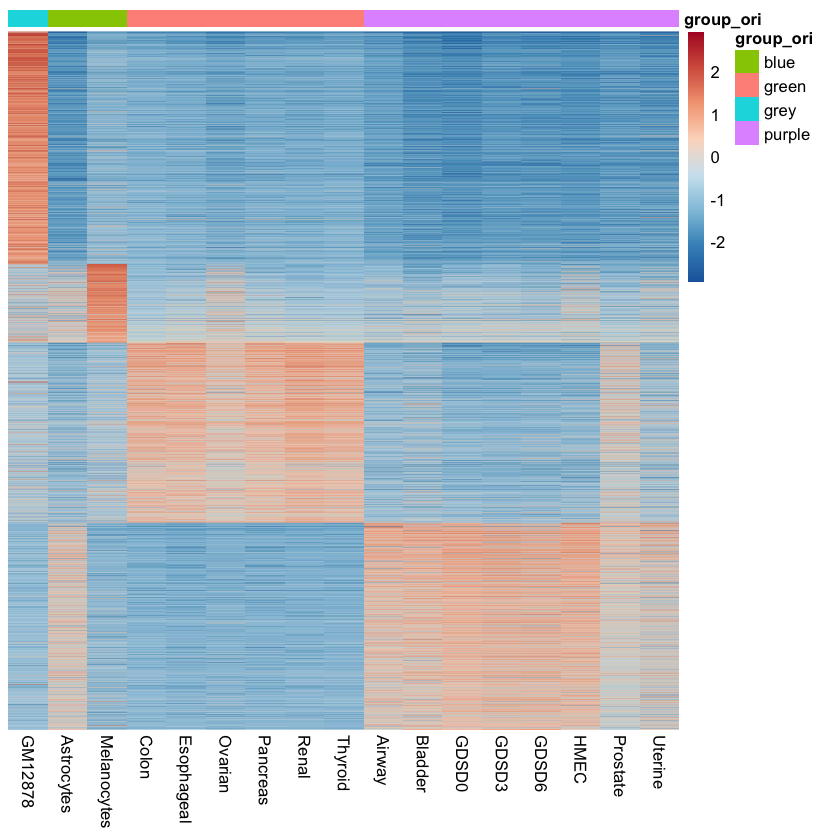

In [183]:
p_10000 = pheatmap(tissue_peak_sig,
             cluster_rows=F,
             cluster_cols=F,
                show_rownames=F,
             annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))
save_pheatmap_png(p_10000, paste0(save_prefix, 'atac_heatmap_no_genes.png'), width=3000, height=3000, res = 500) 

In [189]:
select_genes = peak_to_gene[peak_to_gene$peaks %in% select_peaks, "gene"]
length(select_genes)

[1] 30108

In [209]:
purple_genes= na.omit(unique(sig_gene_list$purple[ sig_gene_list$purple %in% select_genes]))
length(purple_genes)
green_genes =na.omit(unique(sig_gene_list$green[ sig_gene_list$green %in% select_genes]))
length(green_genes)
blue_genes  = na.omit(unique(sig_gene_list$blue[ sig_gene_list$blue %in% select_genes]))
length(blue_genes)
grey_genes  = na.omit(unique(sig_gene_list$grey[ sig_gene_list$grey %in% select_genes]))
length(grey_genes)
all_genes = unique(sig_gene_combined)
length(all_genes)

[1] 7690

[1] 7119

[1] 2848

[1] 7294

[1] 17995

In [210]:
library(VennDiagram)
 
# Chart
venn.diagram(
  x = list(purple_genes, green_genes, blue_genes,grey_genes),
  category.names = c("purple", "green", "blue", "grey"),
  filename = 'atac_venn_diagramm.png',
  output=TRUE
)

[1] 1

In [211]:
write.table(sort(purple_genes), file = paste0(save_prefix, "purple_genes.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(green_genes), file = paste0(save_prefix, "green_genes.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(blue_genes), file = paste0(save_prefix, "blue_genes.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(grey_genes), file = paste0(save_prefix, "grey_genes.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(all_genes), file = paste0(save_prefix, "all_genes.csv"),row.names=FALSE,col.names=FALSE)


# signature checking

In [195]:
purple_entrez = bitr(purple_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
green_entrez = bitr(green_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
blue_entrez = bitr(blue_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
grey_entrez = bitr(grey_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID

all_entrez = bitr(all_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID


'select()' returned 1:many mapping between keys and columns

Warning message in bitr(purple_genes, fromType = "SYMBOL", toType = "ENTREZID", :
"0.01% of input gene IDs are fail to map..."
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(green_genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
"0.01% of input gene IDs are fail to map..."
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(blue_genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
"0.04% of input gene IDs are fail to map..."
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(grey_genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
"0.01% of input gene IDs are fail to map..."
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(all_genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
"0.01% of input gene IDs

In [196]:
length(purple_entrez)
length(green_entrez)
length(blue_entrez)
length(grey_entrez)
length(all_entrez)

[1] 7692

[1] 7120

[1] 2848

[1] 7296

[1] 17998

In [197]:
cluster_all <- list(purple = purple_entrez, 
                       green = green_entrez,
                      blue = blue_entrez,
                      grey = grey_entrez)

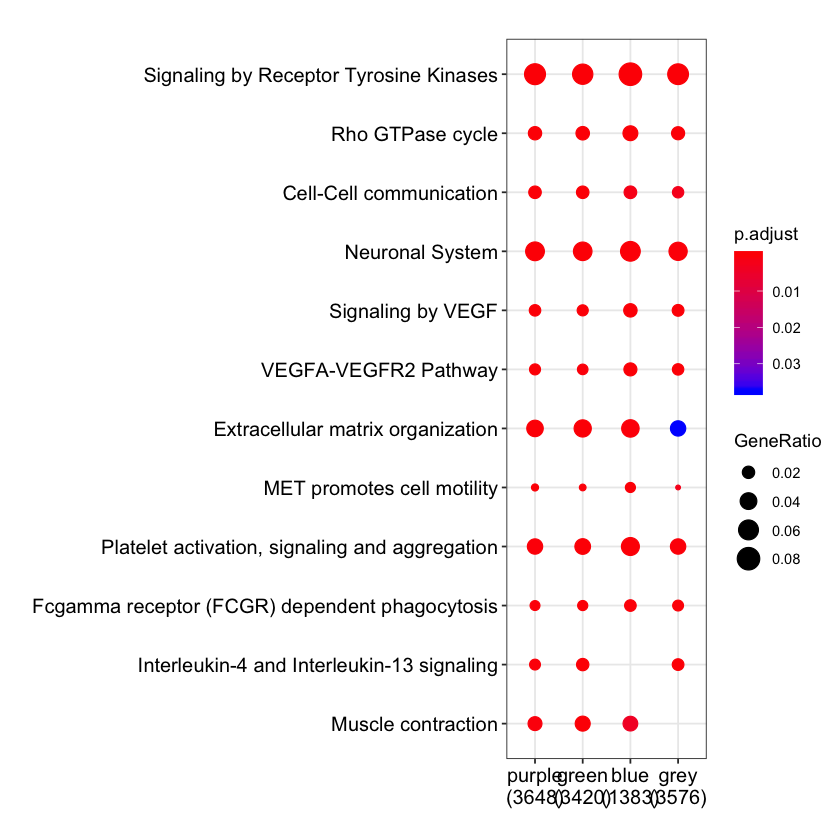

In [198]:
ck_reactome_90 <- compareCluster(geneCluster = cluster_all, 
                                 fun = "enrichPathway", pAdjustMethod='none', pvalueCutoff = 1,readable=TRUE)
write.csv(ck_reactome_90, file = paste0(save_prefix, "ck_reactome_groups.csv"))
dotplot(ck_reactome_90)
ggsave(file = paste0(save_prefix, "ck_reactome_groups.png"),height=7, width=10)

In [199]:
ck_go_bp <- compareCluster(geneCluster = cluster_all, fun = "enrichGO", 
                                pAdjustMethod='BH', 
                                pvalueCutoff  = 0.05,
                                qvalueCutoff  = 0.05,
                                OrgDb='org.Hs.eg.db', 
                                ont = "BP",
                                readable=TRUE)
head(as.data.frame(ck_go_bp))
write.csv(ck_go_bp, file=paste0(save_prefix, 'ck_go_bp_05.csv'))

ck_go_mf <- compareCluster(geneCluster = cluster_all, fun = "enrichGO", 
                                pAdjustMethod='BH', 
                                pvalueCutoff  = 0.05,
                                qvalueCutoff  = 0.05,
                                OrgDb='org.Hs.eg.db', 
                                ont = "MF",
                                readable=TRUE)                              
head(as.data.frame(ck_go_mf))
write.csv(ck_go_mf, file=paste0(save_prefix, 'ck_go_mf_05.csv'))


ck_go_cc <- compareCluster(geneCluster = cluster_all, fun = "enrichGO", 
                                pAdjustMethod='BH', 
                                pvalueCutoff  = 0.05,
                                qvalueCutoff  = 0.05,
                                OrgDb='org.Hs.eg.db', 
                                ont = "CC",
                                readable=TRUE)
head(as.data.frame(ck_go_cc))
write.csv(ck_go_cc, file=paste0(save_prefix, 'ck_go_cc_05.csv'))

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,purple,GO:0007409,axonogenesis,247/5993,468/18670,6.399784e-21,4.132340e-17,2.882597e-17,GATA3/CNTN6/UNC5D/EXT1/EVL/NR4A2/DAB1/NRXN1/CDH11/NR4A3/DOK5/PTPRM/MAP3K13/FOXB1/FGF13/SLIT2/FN1/BMPR1B/CDH2/PARD3/TIAM1/GRB10/NEFL/SEMA6D/CHL1/NCAM1/ITGB1/LAMA1/NRXN3/PRKCQ/EPHA7/AUTS2/STXBP1/SLITRK6/PAFAH1B1/PAK1/NECTIN1/FSTL4/GLI3/CDKL5/SLITRK1/APP/SEMA3C/PTPRZ1/EPHA6/CDH4/SOS1/FGFR2/UNC5B/ROBO2/SRC/NPTN/ARTN/EPHA4/LRRC4C/ALCAM/EPHA3/MCF2/PLXNA2/SEMA3D/EFNA5/PALLD/NTNG1/PTPRO/MYH10/GSK3B/EMB/RUFY3/DSCAM/SEMA3F/CNTN4/LAMA2/NRP2/SEMA6A/PTPRA/LPAR3/HOXA2/ROBO1/SLITRK3/DCC/LGR6/HSP90AA1/PTEN/NGF/SHANK3/WNT7A/LMX1A/MAP2/NIBAN2/ANK3/NTN1/C9orf72/CHODL/B4GALT6/EPHA2/BDNF/TOP2B/SEMA5A/PAK3/NTRK2/SHOX2/NEO1/WNT3A/GBX2/FLRT2/PLXNA1/IRS2/APBB2/GOLGA4/NFIB/MYCBP2/GPC1/ARHGAP35/VANGL2/ZFYVE27/SEMA3E/GLI2/PICALM/S100B/UNC5C/PTK2/PIK3R1/MACF1/NRP1/LHX1/GAB1/EGR2/ETV1/PLXNC1/SEMA6B/RNF165/MAP1B/OPHN1/WNT3/BMP7/B3GNT2/BMPR2/EZR/SLIT3/PIK3CD/POU4F2/DOCK7/BCL11B/SPG11/PIK3CB/ENAH/UST/DCLK1/SEMA4C/ADNP/CCK/GAB2/SEMA5B/ATOH1/COBL/NPTX1/CTNNA2/RAC2/ARHGAP4/HSP90AB1/PITPNA/XK/CYFIP1/GRB7/MATN2/SIPA1L1/SPTBN1/ULK1/SEMA3A/KIF13B/ITGA4/TRAK1/GRB2/KLF7/NRCAM/CREB1/NTN4/CHN1/MAPK1/CDK5R1/RTN4/VSTM2L/NFASC/TNR/ARX/LRTM1/PLXNA4/ISL1/SLC9A6/GDNF/GDF7/VEGFA/PTCH1/FEZ2/TRIO/CRPPA/NIN/PRKCA/SH3KBP1/GAP43/RAPH1/ZSWIM6/RPS6KA5/DOK1/SEMA4D/TBR1/PAX2/EFNB1/SEMA4B/YTHDF1/GFRA1/RAB8A/BARHL2/BCL2/SHH/FYN/DOK4/EPHB3/KIF5C/SPTB/ZEB2/SKIL/MYPN/RANBP9/EFNA2/NKX6-1/RYK/SMAD4/FEZ1/STK11/SPTBN5/POU4F1/PTPRS/ADARB1/NTRK3/SEMA7A/NUMB/ROBO3/LGI1/PARD6B/B4GALT5/EPHA10/PLPPR4/BSG/ABL1/BRSK2/ATL1,247
2,purple,GO:0043087,regulation of GTPase activity,248/5993,479/18670,1.442219e-19,4.408716e-16,3.075389e-16,TBC1D1/MMUT/DEPDC5/DLC1/DOCK1/CXCL13/RAPGEF2/ARAP2/VAV2/SLIT2/TBC1D8/RALGAPA2/TIAM1/SPRY2/CORO1C/AFDN/CHML/ADRB1/ITGB1/ARHGAP25/RGS2/ARHGAP42/DAB2IP/PAFAH1B1/TBCK/TIAM2/RAB3GAP2/CDKL5/RIN3/SRGAP3/TBC1D14/VAV3/SOS1/TBC1D19/SNX13/ASAP3/EPHA4/GRHL3/EPHA3/TBCD/PLXNA2/EFNA5/RABGAP1L/RANGAP1/ALDH1A1/ITGA6/ARHGAP22/RCC2/GSK3B/TSC1/ABR/DOCK5/IQGAP2/RHOH/STXBP5/CHN2/FAM13A/NET1/MAP4K4/CX3CL1/ARHGAP6/ADGRB3/STARD13/RAPGEF1/SBF2/RASAL2/DOCK9/DEPDC1/RANBP3L/IPO5/RGS17/FGD6/SNX9/ZC3H15/GNAQ/MYO9B/DOCK4/SPRY1/RASA4/WNT4/TBC1D22A/EPHA2/SNX18/IQGAP1/CCR7/NTRK2/ARHGEF16/PLCB1/DOCK10/TBC1D5/PLXNA1/ARHGAP20/RASGRP3/ARFGEF1/RALBP1/ARHGAP15/ASAP2/RAP1GDS1/RGS12/GARNL3/ARHGAP35/WNK1/RIN2/TBC1D4/RALGAPB/LIMS1/ARHGEF7/PICALM/EVI5L/MTSS2/PTK2/DEPDC1B/AGAP1/TAGAP/TBC1D9/ARHGAP18/NRP1/AKT2/RGS9/RAP1GAP2/CPEB2/PLXNC1/MYO9A/RGS10/ARHGAP24/OPHN1/FGD3/RGS3/BVES/OCRL/DGKI/LRRK2/ARFGAP3/ARHGAP28/CAV2/DOCK8/DOCK7/F2RL1/DOCK11/ARHGEF12/FAM13B/ARHGAP10/MAPRE2/ARHGAP19/ARHGEF10/RAPGEF3/BCL6/DENND1B/RAB3GAP1/KLRC4-KLRK1/SIPA1L2/RGS8/ARHGAP4/FZD10/SIPA1L1/GAPVD1/KLRK1/CRKL/S100A10/LARS1/MIR223/RASA3/ASAP1/EVI5/DOCK2/CHN1/ARHGEF10L/KALRN/CHM/RGS7/RGS20/F11R/RGS4/RP2/ACAP2/PLXNA4/CD40/FGD2/RGS5/RAB11FIP2/TBC1D30/NTF3/ARAP1/EZH2/SFRP1/ARHGAP32/SEMA4D/ARHGAP29/RASIP1/SIPA1L3/FGD4/MKKS/CCL20/ARHGAP5/SH3BP4/ARHGAP8/IQSEC1/GDI2/ARHGAP23/BCAS3/ARHGAP12/RAPGEF6/ARHGAP21/SRGAP1/TBC1D22B/BCR/TBC1D16/RSU1/MTOR/NEDD9/XCL2/PLEKHG6/USP6NL/RASA2/TBC1D24/PTK2B/RASGRF1/GNB5/EPHB3/AMOT/SRGAP2/RGS1/ECT2/NCKAP1L/S1PR1/TBC1D2/AJUBA/RIC1/F2R/ERRFI1/ARAP3/SOD1/NTRK3/ARHGEF5/TBC1D25/TBC1D9B/SMAP2/RGS6/CCL5/ARHGAP27/LRCH1/SEC23A/RANBP3/RASAL3/TBC1D7/ARHGAP26/ARHGAP17/TBC1D2B,248
3,purple,GO:0034330,cell junction organization,167/5993,290/18670,2.048343e-19,4.408716e-16,3.075389e-16,WDR1/CLASP1/DLC1/MPP7/CDH11/RAPGEF2/GJA1/FN1/CDH2/PARD3/LAMC2/CTNNB1/CORO1C/AFDN/CDH8/PERP/PDCD6IP/LAMA3/DLG5/NECTIN1/POF1B/PKP2/PARD6G/CDH4/CDH18/CADM2/SORBS1/SRC/EPHA3/TBCD/EFNA5/TRPV4/KDR/DSG2/PTPRO/ITGA6/RCC2/FBLIM1/TSC1/TGFBR1/CDH12/ANK2/TJP1/PRKCH/PHLDB2/PTPRK/DSG1/SMAD7/MAP4K4/ARHGAP6/KRT5/PTEN/RAPGEF1/LAMB3/CLDN5/INAVA/PKN2/SDK1/RAP1B/WNT4/CDHR3/SDK2/NF2/EPHA2/IQGAP1/CDH10/GRHL2/TLN2/SLC9A1/CORO2B/PATJ/RUNX1/RAB8B/NPHP4/CDH13/U

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,purple,GO:0031267,small GTPase binding,223/5879,443/17697,3.846181e-14,4.584648e-11,3.728771e-11,TBC1D1/DOCK1/RASGEF1B/XPO6/RAPGEF2/NDRG1/VAV2/TBC1D8/FMNL2/TIAM1/IPO8/PEX5L/CORO1C/AFDN/ARHGEF4/CHML/ADRB1/WDR44/RCBTB2/ERC1/EXOC4/RIMS1/ANKFY1/PAK1/TBCK/MYO5B/TIAM2/RAB3GAP2/CDKL5/NCKAP1/RIN3/SRGAP3/PARD6G/PLEKHG1/PLEKHG5/TBC1D14/VAV3/SOS1/BICD2/WASF1/ANXA2/MYO5A/MCF2/GGA2/ARHGEF28/RNF152/RABGAP1L/RANGAP1/PLEKHG3/KIF3B/RCC2/ABR/IQGAP2/ARHGEF3/RHOH/STXBP5/SYTL2/RIMS2/NET1/DENND3/HPS4/PAK6/PAK2/MAPKAP1/MICAL3/RAPGEF1/CLEC16A/SBF2/EXPH5/RANBP3L/RAPGEF4/IPO5/FGD6/MYO9B/CDC42EP4/DOCK4/SYTL3/PKN2/C9orf72/TBC1D22A/BICDL1/IQGAP1/MYRIP/CDC42EP1/KIF16B/DENND6A/PAK3/WDR41/ARHGEF16/HACE1/TBC1D5/RASGRP3/RALBP1/MYCBP2/RIN2/TBC1D4/AKAP13/SORL1/ITSN1/ARHGEF7/PICALM/EVI5L/MTSS2/CAV1/RAPGEF5/TBC1D9/RAB3IP/DAAM1/CDC42EP3/TRIOBP/DENND2B/STXBP6/CDC42BPB/DIAPH3/EXOC2/FGD3/OCRL/DGKI/SYTL4/LRRK2/RALGPS1/ABCA1/DOCK7/STRIP1/DOCK11/ARHGEF37/RANBP17/ARHGEF12/SLC6A4/ARHGEF10/RAPGEF3/EGF/PAK4/DENND1B/RAB3GAP1/PLCE1/NOXA1/EXOC1/ARHGAP4/SH3BP5/IPO7/CYFIP1/CSE1L/ULK1/PAK5/EVI5/DOCK2/OBSCN/NOX1/ARHGEF10L/KALRN/CHM/CDC42SE2/MCF2L2/FARP2/ACAP2/DNMBP/UNC13B/RPH3AL/RILPL2/RAB11FIP4/TRIO/RHOBTB3/EPS8/FGD2/RAB11FIP2/MCF2L/TBC1D30/DENND2D/PLEKHG7/ARHGEF18/PLEKHG4B/ITSN2/FMNL3/RPH3A/FGD4/EHD1/SH3BP4/ARHGEF26/MICAL1/RAB8A/GDI2/DENND4A/BICD1/RAPGEF6/SRGAP1/TBC1D22B/BCR/TBC1D16/ARHGEF2/MICALL2/DMXL2/ECT2L/PLEKHG6/TRAPPC3/USP6NL/DENND5A/RASGRF1/SRGAP2/ECT2/NCKAP1L/RANBP9/IPO11/XPO7/RAB29/UNC13D/SBK2/TBC1D2/SYTL5/EPS8L3/RIC1/ERRFI1/SOD1/ARHGEF5/TBC1D25/TBC1D9B/PARD6B/AP3M1/RABGEF1/RANBP3/TBC1D7/ARHGAP17/TBC1D2B,223
2,purple,GO:0017016,Ras GTPase binding,216/5879,429/17697,9.440747e-14,5.626685e-11,4.576278e-11,TBC1D1/DOCK1/RASGEF1B/XPO6/RAPGEF2/NDRG1/VAV2/TBC1D8/FMNL2/TIAM1/IPO8/CORO1C/AFDN/ARHGEF4/CHML/ADRB1/WDR44/RCBTB2/ERC1/EXOC4/RIMS1/ANKFY1/PAK1/TBCK/MYO5B/TIAM2/RAB3GAP2/CDKL5/NCKAP1/RIN3/SRGAP3/PARD6G/PLEKHG1/PLEKHG5/TBC1D14/VAV3/SOS1/BICD2/WASF1/ANXA2/MYO5A/MCF2/ARHGEF28/RABGAP1L/RANGAP1/PLEKHG3/KIF3B/RCC2/ABR/IQGAP2/ARHGEF3/RHOH/STXBP5/SYTL2/RIMS2/NET1/DENND3/HPS4/PAK6/PAK2/MAPKAP1/MICAL3/RAPGEF1/CLEC16A/SBF2/EXPH5/RANBP3L/RAPGEF4/IPO5/FGD6/MYO9B/CDC42EP4/DOCK4/SYTL3/PKN2/C9orf72/TBC1D22A/BICDL1/IQGAP1/MYRIP/CDC42EP1/KIF16B/DENND6A/PAK3/WDR41/ARHGEF16/HACE1/TBC1D5/RASGRP3/RALBP1/MYCBP2/RIN2/TBC1D4/AKAP13/ITSN1/ARHGEF7/PICALM/EVI5L/MTSS2/CAV1/RAPGEF5/TBC1D9/RAB3IP/DAAM1/CDC42EP3/TRIOBP/DENND2B/STXBP6/CDC42BPB/DIAPH3/EXOC2/FGD3/OCRL/DGKI/SYTL4/LRRK2/RALGPS1/DOCK7/STRIP1/DOCK11/ARHGEF37/RANBP17/ARHGEF12/SLC6A4/ARHGEF10/RAPGEF3/EGF/PAK4/DENND1B/RAB3GAP1/PLCE1/NOXA1/EXOC1/ARHGAP4/SH3BP5/IPO7/CYFIP1/CSE1L/ULK1/PAK5/EVI5/DOCK2/OBSCN/NOX1/ARHGEF10L/KALRN/CHM/CDC42SE2/MCF2L2/FARP2/ACAP2/DNMBP/UNC13B/RPH3AL/RAB11FIP4/TRIO/RHOBTB3/EPS8/FGD2/RAB11FIP2/MCF2L/TBC1D30/DENND2D/PLEKHG7/ARHGEF18/PLEKHG4B/ITSN2/FMNL3/RPH3A/FGD4/EHD1/SH3BP4/ARHGEF26/MICAL1/RAB8A/GDI2/DENND4A/BICD1/RAPGEF6/SRGAP1/TBC1D22B/BCR/TBC1D16/ARHGEF2/MICALL2/DMXL2/ECT2L/PLEKHG6/TRAPPC3/USP6NL/DENND5A/RASGRF1/SRGAP2/ECT2/NCKAP1L/RANBP9/IPO11/XPO7/RAB29/UNC13D/SBK2/TBC1D2/SYTL5/EPS8L3/RIC1/SOD1/ARHGEF5/TBC1D25/TBC1D9B/PARD6B/AP3M1/RABGEF1/RANBP3/TBC1D7/ARHGAP17/TBC1D2B,216
3,purple,GO:0050839,cell adhesion molecule binding,238/5879,499/17697,7.931829e-12,3.151580e-09,2.563233e-09,MYO1B/ADAMTS5/COBLL1/NRXN1/MPP7/CCN6/CDH11/PPFIBP1/NDRG1/PTPRD/PTPRM/NRG1/TENM2/FGF1/FN1/MRTFB/ANXA1/FMNL2/CDH2/FRMD5/MPRIP/CTNNB1/AFDN/CDH8/EGFR/ITGB1/ERC1/NRXN3/DNAJB1/LAMA3/DAB2IP/NECTIN1/SERBP1/EGFL6/PKP2/NPNT/PTPRZ1/IL1B/CDH4/CDH18/DCHS2/TENM3/SRC/NPTN/EFHD2/P2RX4/LRRC4C/ANXA2/SLC14A2/TRIM29/KDR/TENM4/RANGAP1/DSG2/NTNG1/PTPRO/ITGA6/LGALS8/WASF2/EDIL3/PACSIN2/CDH12/TNKS1BP1/TJP1/PHLDB2/ADAMTS8/SH3GL1/CCN4/ACVR1/TGFBI/VWF/MSN/PAK6/PAK2/KIF5B/CX3CL1/EMP2/LIMA1/ESM1/DOCK9/CALD1/GPNMB/TRIM25/SNX9/ZC3H15/SWAP70/NIBAN2/ANK3/PKN2/CDHR3/EPHA2/IQGAP1/CDC42EP1/SFN/CDH10/ARHGEF16/HDLBP/TWF1/STK24/SYK/CTNNAL1/L

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,purple,GO:0005911,cell-cell junction,233/6252,459/19717,8.276359e-18,3.253690e-15,2.570915e-15,WDR1/CLDN17/PTPRU/AMTN/MPP7/ACTR3/CD99L2/CDH11/RAPGEF2/NDRG1/GJA1/PTPRM/FGF13/ANXA1/ILDR1/KCNJ2/CDH2/PARD3/TIAM1/SYNPO/CTNNB1/FAT2/AFDN/CDH8/SCN1A/ITGB1/LAMA1/PERP/CLDN14/PDCD6IP/PAK1/DLG5/NECTIN1/POF1B/AMOTL1/ADGRL3/PKP2/FRMD6/TRPC6/APP/PARD6G/EPB41L4B/PLEKHG5/MAGI1/CDH4/CDH18/CLDN24/DSG3/SORBS1/FAT1/JCAD/ANXA2/KIRREL1/TBCD/TRIM29/DSG2/KAZN/ITGA6/CDC42BPA/WASF2/PTK7/PACSIN2/TGFBR1/CDH12/ANK2/TNKS1BP1/SLC2A1/TJP1/ATP1A1/AJAP1/CD2/PCDH9/FRMD4B/PTPRK/KIT/DSC3/DSG1/MAGI3/SMAD7/GJA10/ATP2A2/PANX1/CLDN5/MYO1E/LRRC7/ANK3/SHROOM4/CDC42EP4/PKN2/RAP1B/CDHR3/EPHA2/IQGAP1/RAP2B/CDC42EP1/TMEM47/CDH10/GRHL2/TWF1/FLRT2/SLC9A1/PATJ/PDLIM1/NPHP4/RAP2C/AKR1B1/CDH13/PDLIM5/LYN/VANGL2/LIMS1/CDH20/PPP3CA/CDH6/TRPC4/PIK3R1/CDH9/HMCN1/ATP1A2/CLDN16/PDLIM3/ATP1B1/MPDZ/CDH1/AQP3/GAB1/SSX2IP/DPP4/TEK/AKAP6/STXBP6/COL17A1/JUP/CADM1/MAGI2/NPHP1/CDC42BPB/PPL/CLDN1/PIKFYVE/BVES/CDH5/SLC5A1/BMPR2/ABCC2/MYH9/PARD3B/PAK4/VAPA/KIFC3/CTNNA2/CALB2/CDH7/GRB2/CASK/APC/EPCAM/SLC8A1/MARVELD2/FRMD4A/CDH26/CLDN23/NFASC/SHROOM2/CDH22/CNTNAP2/F11R/TRAF4/PLEKHA7/DNMBP/CDH19/FRMPD2/VEGFA/PDZD2/CTNND1/CYTH1/CLDN20/EPB41L3/PRKCD/SH3KBP1/SDCCAG8/RASIP1/SIPA1L3/PDLIM4/DLG1/ABCB11/CLIC4/CD2AP/HEG1/CSK/KRT8/ARHGEF2/MICALL2/CLDN12/PODXL/PRKCZ/CD53/HPN/FZD5/CCN3/CLDN10/CLMP/CXADR/B4GALT1/KCNA5/PCDH1/ACTN1/SCN5A/AMOT/JAML/GJB5/CLDN18/FSCN1/COL13A1/ECT2/OXTR/CTNNA1/BAIAP2L1/ADD3/OCLN/NHS/AJUBA/CDH17/CD3E/ADD1/PTPRJ/PARD6B/SHROOM3/SKAP1/KCNA2/MTDH/CCND1/ARHGAP17,233
2,purple,GO:0031252,cell leading edge,210/6252,403/19717,8.407468e-18,3.253690e-15,2.570915e-15,EVL/KANK1/DLC1/ACTR3/TPM1/PTPRM/PSD3/ANK1/CDH2/SHISA7/TIAM1/MCC/SPRY2/GABRG3/LAYN/CTNNB1/CORO1C/ARHGEF4/ITGB1/ADGRV1/PAFAH1B1/PAK1/CARMIL1/TIAM2/AMOTL1/CDKL5/NCKAP1/SAMSN1/APP/SYNE2/PLEKHG5/WASF1/ASAP3/SORBS2/ROBO2/FAT1/SRC/JCAD/CDK6/ANXA2/MYO5A/PALLD/TRPV4/PTPRO/SH3RF1/CDC42BPA/WASF2/GRIA1/MYH10/PACSIN2/TSC1/IQGAP2/RUFY3/DUOX2/WWC1/CD44/PHLDB2/FRMD4B/OPRM1/PTPRK/GABRA2/LAMP5/AMPH/WASL/SH3YL1/LIMA1/FGD6/SNX9/SWAP70/STX2/PKN2/NF2/EPHA2/KLHL2/IQGAP1/PHACTR4/KSR1/KCNC2/KCNC1/VIM/TLN2/TWF1/SNTG1/WLS/SLC9A1/APBB2/PDPN/SSH1/THEM4/MYO10/SNX5/ABLIM1/ITSN1/ARHGEF7/PLEK2/S100B/MTSS2/AAK1/PXN/UNC5C/PARVA/DST/PLEKHA1/WASF3/PTK2/SLK/GABRG1/MKLN1/SPRY4/CDH1/MACF1/KITLG/AKT2/SSX2IP/DPP4/PARVB/RAB3IP/DYSF/RIPOR2/CDC42BPB/PSD4/FGD3/PTPN13/PIP5K1C/EZR/FER/DOCK8/SLC39A14/MYH9/ENAH/PLA2G4F/TESC/DGKZ/CLASP2/BMX/RAPGEF3/COBL/CTNNA2/RAC2/CYFIP1/JMY/SPTBN1/GSN/PPP1R9A/ANTXR1/PACSIN1/APC/TACR3/ABI1/MYLK/MYO1D/PSD2/CNTNAP2/SH2B2/ATP6V1B2/MTSS1/CTNND1/APPL2/EPB41L3/EPS8/PDE9A/FGD2/SLC1A2/RAPH1/ACTG2/SCIMP/FGD4/PDLIM4/STMN2/ARHGEF26/FGR/FAP/CD2AP/PSTPIP1/CSPG4/BCAS3/ARHGEF2/PODXL/GPER1/NEDD9/PRKCZ/SNX2/PLEK/DUSP22/LCP1/PTK2B/ACTN1/AMOT/ITGB4/SRGAP2/FSCN1/LDB2/SRCIN1/CTNNA1/MYO6/DPYSL3/MTMR6/EPS8L3/NHS/MYO1G/AJUBA/CLIP1/ABLIM3/ARAP3/PTPRJ/SKAP1/KCNA2/ITGB3/ABL1/PIEZO1,210
3,purple,GO:0098978,glutamatergic synapse,178/6252,349/19717,3.644186e-14,9.401999e-12,7.429024e-12,IL1RAPL2/NRXN1/CDH11/NDRG1/PTPRD/NRG1/SHISA7/TIAM1/SYNPO/CDH8/ITGB1/SPARC/EPHA7/CHRM3/DNAJB1/STXBP1/ACTBL2/GPC6/SYN3/PCDH8/CDKL5/ADGRL3/SLITRK1/PPP2R2A/SORCS3/ELAVL1/GRIK2/PLCB4/MAPK10/ADRA1A/GRIP1/CLSTN1/ATP2B4/SRC/NPTN/EPHA4/LRRC4C/MYO5A/CAMK4/NETO1/ABHD17C/NTNG1/CTTNBP2/PTPRO/GRIA1/MYH10/ARHGAP22/GRID2/GSK3B/PACSIN2/ABR/SEMA3F/NRP2/SH3GL1/P2RY1/IL1RAP/PAK2/DTNBP1/TANC2/CALB1/DGKB/WNT7A/CBLN1/EIF4E/DLG2/ERC2/RGS7BP/FRMPD4/PPM1H/LRRTM3/NCS1/GPM6A/PAK3/CDH10/ERBB4/PLCB1/PRKAR1B/WNT3A/CNKSR2/GRID1/GRIN2A/NRG3/APBA1/ADCY8/NSG1/C1QBP/SYT1/LRFN5/DNM3/KCND2/LYN/ITSN1/PPP3CA/CTBP2/HTR2A/CHMP2B/LRRTM2/WASF3/CRTC1/CDH1/PLEKHA5/YWHAZ/NRP1/NLGN4X/RGS9/GRM1/OPHN1/GHSR/LRRC4/IL1RAPL1/TNIK/ADAM10/DGKI/LRRK2/USP46/KCNA1/DRD1/CADPS/GUCY1A1/DGKZ/GSG1L/SYT6/SEPTIN11/NPTX1/CLSTN2/GPC4/SPTBN1/PPP1R9A/AKAP9/NRCAM/PSD2/TNR/UNC13B/SYT4/SPARCL1/CTNND1/ADAM23/EPS8/SLC1A2/BSN/CACNG

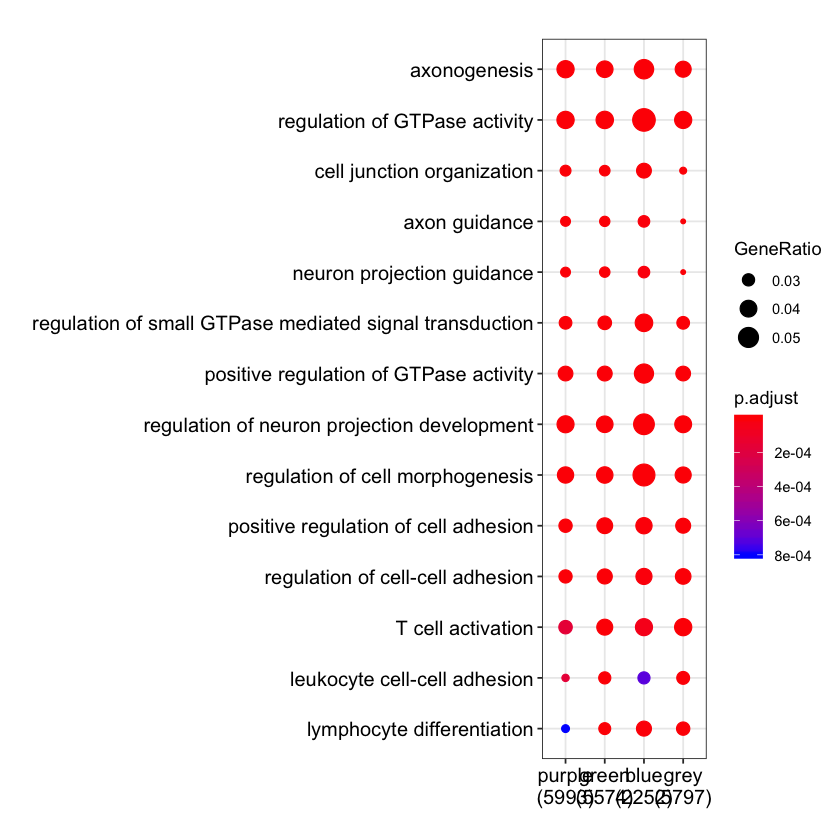

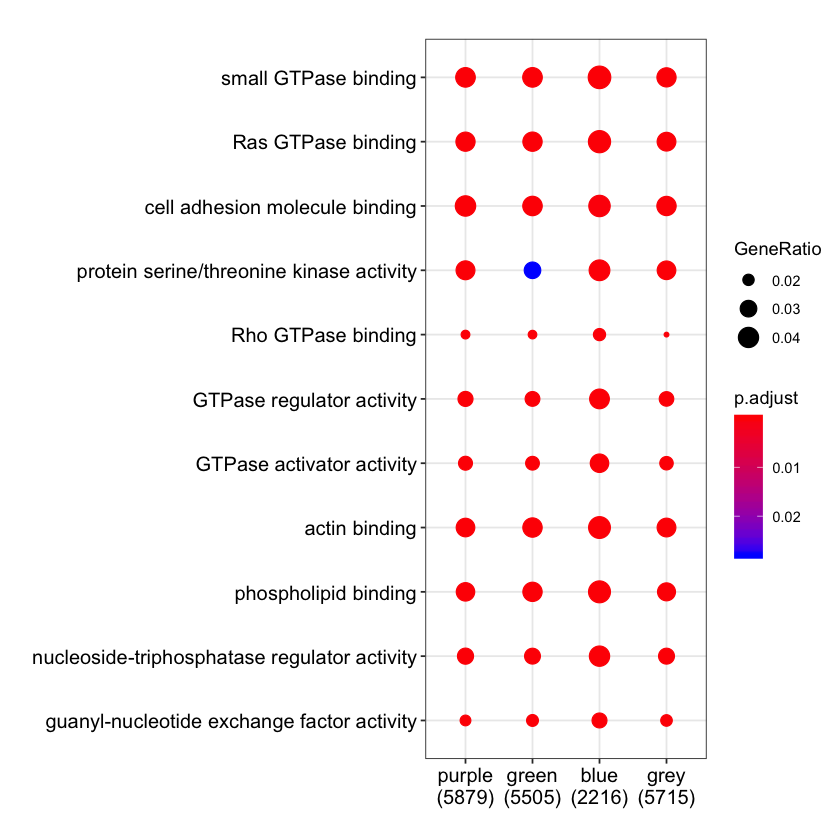

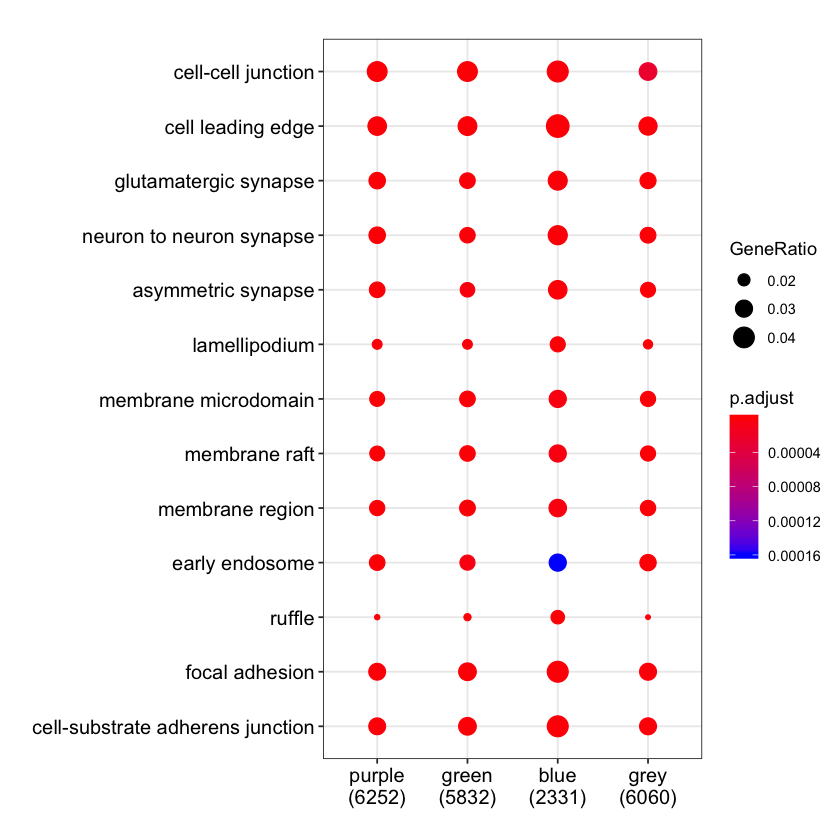

In [200]:
dotplot(ck_go_bp)
ggsave(file = paste0(save_prefix, "ck_go_bp_groups.png"),height=7, width=10)
dotplot(ck_go_mf)
ggsave(file = paste0(save_prefix, "ck_go_mf_groups.png"),height=7, width=10)
dotplot(ck_go_cc)
ggsave(file = paste0(save_prefix, "ck_go_cc_groups.png"),height=7, width=10)

,PC1,PC2,group,Group,name
,<dbl>,<dbl>,<fct>,<fct>,<fct>
Airway,-162.48966,17.810539,purple,purple,Airway
Astrocytes,-188.65343,23.255769,blue,blue,Astrocytes
Bladder,-169.17052,-4.191142,purple,purple,Bladder
Colon,234.86251,-113.388928,green,green,Colon
Esophageal,257.61013,-131.907176,green,green,Esophageal
GDSD0,-262.33544,10.304638,purple,purple,GDSD0
GDSD3,-284.89640,25.817517,purple,purple,GDSD3
GDSD6,-295.19044,19.235467,purple,purple,GDSD6
GM12878,285.71799,632.692294,grey,grey,GM12878


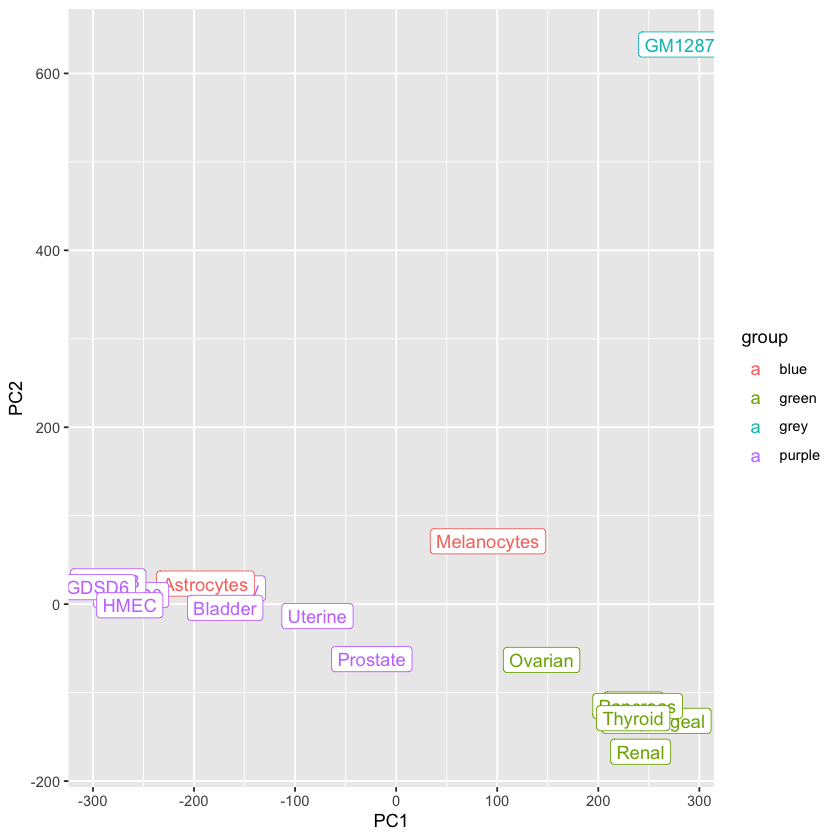

In [101]:
pca_df = plotPCA(atac_Rlog, intgroup = "Group", ntop = nrow(atac_Rlog),returnData=TRUE)
pca_df
ggplot(pca_df, aes(x=PC1, y=PC2, color=group,label=name))+
    geom_point()+
     geom_label()

In [162]:
# green_grey <- results(atacDDS, c("Group", "green", "grey"), format = "GRanges")
# green_grey <- green_grey[order(green_grey$pvalue)]
# green_grey_anno = annotatePeak(green_grey, TxDb = TxDb.Hsapiens.UCSC.hg19.knownGene)

In [161]:
# green_grey_anno
# green_grey_anno_df <- as.data.frame(green_grey_anno)
# green_grey_anno_df$symbol <- mapIds(org.Hs.eg.db, keys=green_grey_anno_df$geneId, column="SYMBOL", keytype="ENTREZID", multiVals="first")
# green_grey_anno_df = green_grey_anno_df%>%
#     mutate(name = paste('ID', seqnames, as.character(start),as.character(end), sep = "_"))
# head(green_grey_anno_df)
# colnames(green_grey_anno_df)

# version B

In [119]:
normal_tissue_order = c('GM12878',
                        'Astrocytes', 'Melanocytes',
                         'Colon',  'Esophageal','Ovarian', 'Pancreas','Renal','Thyroid',
                        'Airway','Bladder','GDSD0','GDSD3','GDSD6','HMEC','Prostate','Uterine')


In [109]:

createSig <- function (data, metadata, col_sel,tissue=TRUE, logFC_thres=.1, p_thres=0.05,max_return = -1) {
    # Differential expression analysis with limmma
    # This function takes in a target
    # Output is a result table of differential expression analysis for target vs control

    # load data and preprocess
    if (tissue){
    metadata = metadata %>% 
        mutate(label = if_else(tissues==col_sel, 'target', 'control'))
    }
    else{
         metadata = metadata %>% 
        mutate(label = if_else(group==col_sel, 'target', 'control'))
    }

    # set up the design
    labels <- factor(metadata$label)
    design <- model.matrix(~ labels + 1)
    colnames(design) <- levels(labels)
    rownames(design) <- metadata$tissue

    # proceed with analysis
    fit <- lmFit(data, design)
    fit <- eBayes(fit, trend=TRUE)
    tT = topTable(fit, coef=ncol(design),adjust="fdr", sort.by="p", number=Inf)
    tT$gene = rownames(tT)
    tT = na.omit(tT)
    tT_filt = tT[tT$logFC>logFC_thres  & tT$adj.P.Val<p_thres,]
    tT_filt = tT_filt%>% arrange(adj.P.Val)%>% arrange(desc(logFC))
    print(dim(tT_filt))
    if( max_return >0){
        tT_filt = tT_filt[1:min(max_return, dim(tT_filt)[1]),]
    }
  return(tT_filt)
}

In [111]:
log_counts = log2(myCounts+1)
log_counts_norm = as.data.frame(scale(log_counts, center = TRUE, scale = TRUE))


,Airway,Astrocytes,Bladder,Colon,Esophageal,GDSD0,GDSD3,GDSD6,GM12878,HMEC,Melanocytes,Ovarian,Pancreas,Prostate,Renal,Thyroid,Uterine
ID_chr20_71094_71649,7.900867,8.335390,7.400879,3.459432,4.087463,8.761551,8.867279,9.278449,2.807355,9.243174,3.000000,4.000000,4.523562,5.087463,4.247928,4.247928,7.787903
ID_chr20_174960_175243,3.000000,3.321928,5.857981,3.169925,3.906891,3.000000,2.584963,1.584963,3.000000,1.584963,2.000000,2.807355,3.000000,1.584963,3.000000,2.584963,4.169925
ID_chr20_189616_190068,7.076816,7.238405,6.930737,6.459432,6.741467,7.794416,7.459432,7.741467,6.108524,7.348728,8.409391,6.727920,7.011227,6.129283,6.087463,6.375039,7.228819
ID_chr20_200277_200455,5.087463,5.392317,5.930737,6.022368,6.000000,6.209453,6.044394,6.129283,4.000000,5.977280,5.000000,5.357552,5.523562,4.459432,5.000000,5.491853,5.754888
ID_chr20_216621_217042,6.129283,6.303781,6.781360,4.700440,4.754888,7.672425,7.159871,7.707359,3.584963,7.734710,6.475733,4.392317,4.807355,6.066089,4.087463,4.584963,6.614710
ID_chr20_239658_239899,5.426265,4.247928,3.700440,6.044394,6.700440,5.491853,5.000000,5.169925,4.087463,4.643856,5.169925,5.491853,5.832890,5.321928,5.000000,5.906891,5.643856
ID_chr20_247309_248054,7.179909,7.734710,6.475733,7.417853,7.936638,7.076816,7.483816,6.954196,7.515700,7.266787,7.977280,7.900867,7.665336,7.076816,7.392317,7.228819,8.199672
ID_chr20_270484_271555,8.159871,8.980140,8.257388,8.573647,8.900867,8.682995,8.957102,8.794416,8.791163,8.108524,9.746514,8.675957,8.647458,7.948367,8.294621,8.495855,9.273796
ID_chr20_277810_279497,9.658211,10.537218,9.784635,10.004220,10.504819,10.573647,10.738092,10.773139,9.890264,10.079485,10.694358,9.812177,10.096715,9.571753,9.634811,9.936638,11.011227
ID_chr20_282577_282876,3.906891,7.426265,7.033423,3.169925,2.584963,7.554589,8.339850,7.918863,5.209453,7.714246,4.584963,2.807355,3.700440,4.584963,3.321928,2.321928,4.000000


In [128]:
metadata = pca_df %>%
    dplyr::select(name, group)
colnames(metadata) =     c('tissues', 'group')

metadata$group = as.character(metadata$group)
metadata['Astrocytes','group'] = 'blue1'
metadata['Melanocytes','group'] = 'blue2'
metadata$group = as.factor(metadata$group)

metadata

,tissues,group
,<fct>,<fct>
Airway,Airway,purple
Astrocytes,Astrocytes,blue1
Bladder,Bladder,purple
Colon,Colon,green
Esophageal,Esophageal,green
GDSD0,GDSD0,purple
GDSD3,GDSD3,purple
GDSD6,GDSD6,purple
GM12878,GM12878,grey


In [129]:
#### per group


sig_peak_list = list()
sig_peak_combined = c()
# for (group in c("grey","blue", "green","purple")){
for (group in c("grey","blue1", 'blue2', "green","purple")){
    tT_filt = createSig(log_counts, metadata,  col_sel=group,tissue=FALSE,max_return = 20000)
    print(group)
    print(dim(tT_filt))
    sig_peak_list[[group]] = tT_filt$gene
    sig_peak_combined = c(sig_peak_combined,tT_filt$gene)
}

[1] 18839     7
[1] "grey"
[1] 18839     7
[1] 0 7
[1] "blue1"
[1] 1 7
[1] 584   7
[1] "blue2"
[1] 584   7
[1] 33095     7
[1] "green"
[1] 20000     7
[1] 34528     7
[1] "purple"
[1] 20000     7


# how to annotate peaks

In [34]:
peaks = toGRanges('Airway_rep1-rep2.idr0.05.bfilt.narrowPeak', format="narrowPeak", header=FALSE) 
peaksAnno = annotatePeak(peaks, TxDb = TxDb.Hsapiens.UCSC.hg19.knownGene)

duplicated or NA names found. Rename all the names by numbers.



>> preparing features information...		 2020-05-05 22:32:18 
>> identifying nearest features...		 2020-05-05 22:32:18 
>> calculating distance from peak to TSS...	 2020-05-05 22:32:20 
>> assigning genomic annotation...		 2020-05-05 22:32:20 
>> assigning chromosome lengths			 2020-05-05 22:32:23 
>> done...					 2020-05-05 22:32:23 


In [35]:
peaksAnno

Annotated peaks generated by ChIPseeker
173423/173423  peaks were annotated
Genomic Annotation Summary:
              Feature  Frequency
9    Promoter (<=1kb) 34.4100840
10   Promoter (1-2kb)  2.9961424
11   Promoter (2-3kb)  2.1715689
4              5' UTR  0.3678866
3              3' UTR  1.4617438
1            1st Exon  0.5731650
7          Other Exon  2.3370603
2          1st Intron  8.3962335
8        Other Intron 17.9405269
6  Downstream (<=300)  1.0137064
5   Distal Intergenic 28.3318822

In [4]:
# genesLocations <- genes(TxDb.Hsapiens.UCSC.hg19.knownGene)
# genesLocations

GRanges object with 23056 ranges and 1 metadata column:
        seqnames              ranges strand |     gene_id
           <Rle>           <IRanges>  <Rle> | <character>
      1    chr19   58858172-58874214      - |           1
     10     chr8   18248755-18258723      + |          10
    100    chr20   43248163-43280376      - |         100
   1000    chr18   25530930-25757445      - |        1000
  10000     chr1 243651535-244006886      - |       10000
    ...      ...                 ...    ... .         ...
   9991     chr9 114979995-115095944      - |        9991
   9992    chr21   35736323-35743440      + |        9992
   9993    chr22   19023795-19109967      - |        9993
   9994     chr6   90539619-90584155      + |        9994
   9997    chr22   50961997-50964905      - |        9997
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

In [ ]:
## Making a "short cut"
edb <- EnsDb.Hsapiens.v86
## print some informations for this package
edb

## create annotation file from EnsDb or TxDb
annoData <- toGRanges(edb, feature="gene")
annoData[1:2]


In [ ]:
MacsGR_Anno <- as.GRanges(MacsCalls_Anno)
MacsGR_TSS <-   MacsGR_Anno[abs(MacsGR_Anno$distanceToTSS) < 500]
MacsGR_TSS[1,]